In [1]:
# %load ./init.ipy
%reload_ext autoreload
%autoreload 2
from importlib import reload

import os
import sys
import logging
import warnings
import numpy as np
import astropy as ap
import scipy as sp
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt

import h5py
import tqdm.notebook as tqdm

import kalepy as kale
# import kalepy.utils
import kalepy.plot

import holodeck as holo
import holodeck.sam
from holodeck import utils, plot  # , cosmo
from holodeck.constants import MSOL, PC, YR, MPC, GYR, SPLC

# Silence annoying numpy errors
np.seterr(divide='ignore', invalid='ignore', over='ignore')
warnings.filterwarnings("ignore", category=UserWarning)

# Plotting settings
mpl.rc('font', **{'family': 'serif', 'sans-serif': ['Times'], 'size': 15})
mpl.rc('lines', solid_capstyle='round')
mpl.rc('mathtext', fontset='cm')
plt.rcParams.update({'grid.alpha': 0.5})

log = holo.log
log.setLevel(logging.INFO)

# Quick Start

In [2]:
# ---- Construct S.A.M. with default settings ----
sam = holo.sam.Semi_Analytic_Model()

In [3]:
# ---- Choose frequencies, and calculate GWB ----
fobs = utils.nyquist_freqs()

In [4]:
edges, number, hs = sam.number_from_hardening(holo.evolution.Hard_GW, fobs=fobs)


In [5]:
bin_vol = np.diff(np.log10(edges[0]))[0]
for ii in range(1, len(edges)):
    bin_vol *= np.diff(edges[ii])[0]

print(f"{bin_vol:.2e}")

1.65e-05


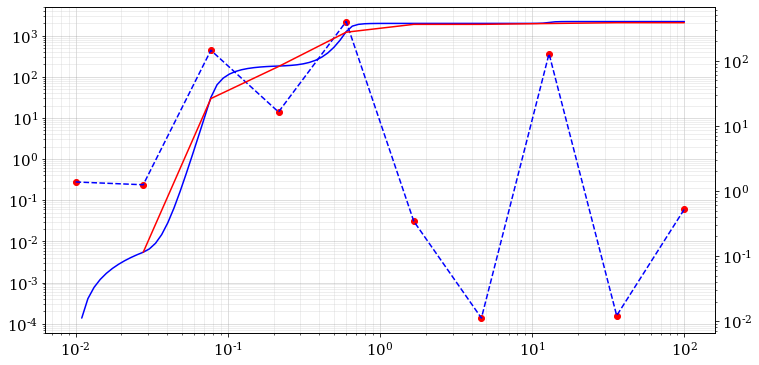

In [15]:
ylo = np.random.uniform(-4, 4, 10)
xlo = np.logspace(-2, 2, ylo.size)
xhi = np.logspace(-2, 2, ylo.size * 10)
yhi = np.interp(np.log10(xhi), np.log10(xlo), ylo)
ylo = 10**ylo
yhi = 10**yhi

fig, ax = plot.figax()
tw = ax.twinx()
tw.set(yscale='log')
ax.plot(xlo, ylo, 'ro')
ax.plot(xhi, yhi, 'b--')

z1 = utils.trapz(yhi, np.log10(xhi))
tw.plot(xhi[1:], z1, 'b-')

z2 = utils.trapz_loglog(ylo, xlo, dlogx=10.0)
tw.plot(xlo[1:], z2, 'r-')


In [22]:
# gwb = np.random.poisson(number) * hs**2
num = number
num = holo.utils.trapz_loglog(num, edges[0], dlogx=10.0, axis=0)
# num = holo.utils.trapz(num, np.log10(edges[0]), axis=0)
num = np.nan_to_num(num)
print(f"{num.sum():.4e}")

num = holo.utils.trapz(num, edges[1], axis=1)
num = np.nan_to_num(num)
print(f"{num.sum():.4e}")
num = holo.utils.trapz(num, edges[2], axis=2)
num = np.nan_to_num(num)
print(f"{num.sum():.4e}")

gwb = np.random.poisson(num) * kale.utils.midpoints(hs, log=True, axis=(0, 1, 2)) ** 2
gwb = np.nan_to_num(gwb)
gwb = np.sqrt(np.sum(gwb, axis=(0, 1, 2)))


nan
nan
nan
0.0000e+00


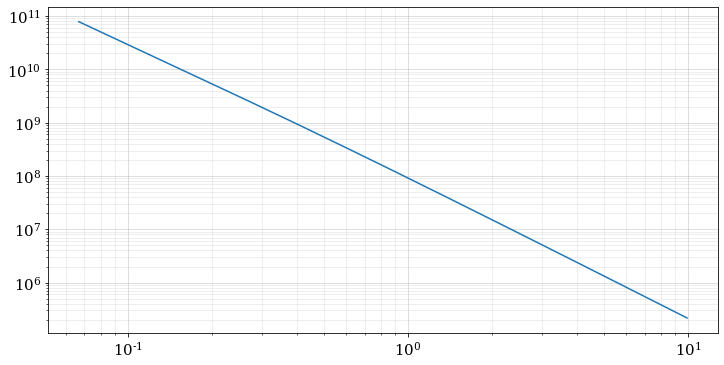

In [8]:
fig, ax = plot.figax()
ax.plot(fobs[:-1], num.sum(axis=(0, 1, 2)))

# plt.show()

NameError: name 'gwb' is not defined

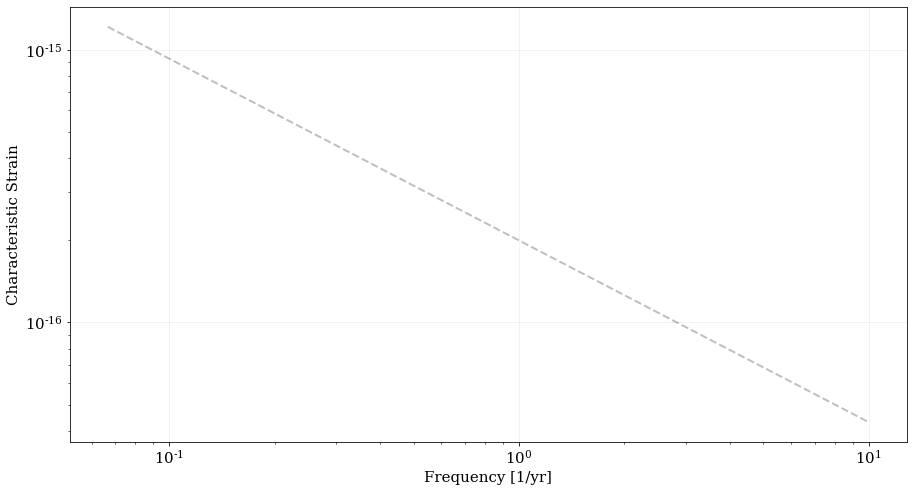

In [9]:
# ---- Plot GWB ----

fig, ax = plt.subplots(figsize=[15, 8])
ax.set(xscale='log', xlabel='Frequency [1/yr]', yscale='log', ylabel='Characteristic Strain')
ax.grid(alpha=0.2)

yy = 2e-16 * np.power(fobs, -2.0/3.0)
ax.plot(fobs, yy, 'k--', alpha=0.25, lw=2.0)
ax.plot(fobs, np.median(gwb, axis=-1), 'k-')
for pp in [50, 98]:
    percs = pp / 2
    percs = [50 - percs, 50 + percs]
    ax.fill_between(fobs, *np.percentile(gwb, percs, axis=-1), alpha=0.25, color='b')

plt.show()

In [ ]:
gwb = sam.gwb(fobs, realize=10)    # calculate 10 different realizations

In [ ]:
# ---- Plot GWB ----

fig, ax = plt.subplots(figsize=[15, 8])
ax.set(xscale='log', xlabel='Frequency [1/yr]', yscale='log', ylabel='Characteristic Strain')
ax.grid(alpha=0.2)

xx = fobs * YR
yy = 2e-16 * np.power(xx, -2.0/3.0)
ax.plot(xx, yy, 'k--', alpha=0.25, lw=2.0)
ax.plot(xx, np.median(gwb, axis=-1), 'k-')
for pp in [50, 98]:
    percs = pp / 2
    percs = [50 - percs, 50 + percs]
    ax.fill_between(xx, *np.percentile(gwb, percs, axis=-1), alpha=0.25, color='b')

plt.show()

# build SAM component-by-component

In [ ]:
gsmf = holo.sam.GSMF_Schechter()        # Galaxy Stellar-Mass Function (GSMF)
gpf = holo.sam.GPF_Power_Law()          # Galaxy Pair Fraction         (GPF)
gmt = holo.sam.GMT_Power_Law()          # Galaxy Merger Time           (GMT)
mmbulge = holo.sam.MMBulge_Simple()

sam = holo.sam.Semi_Analytic_Model(gsmf=gsmf, gpf=gpf, gmt=gmt, mmbulge=mmbulge)

In [ ]:
# ---- Calculate GWB Amplitude distribution at 1/yr ----
ayr = sam.gwb(1.0/YR, realize=100)

In [ ]:
fig, ax = plt.subplots(figsize=[10, 6])
ax.set(xlabel=r'$\log_{10}(A_\mathrm{yr})$', ylabel='Probability Density')
ax.grid(alpha=0.2)
kale.dist1d(np.log10(ayr), density=True, confidence=True)

plt.show()

## Plot GWB Amplitude Distribution vs. M-MBulge parameters

In [ ]:
alpha_list = [0.75, 1.0, 1.25]
norm_list = np.logspace(7, 9, 11)
NREALS = 100
FREQ = 1.0 / YR   # [1/s]

dist_mmb = np.zeros((len(alpha_list), norm_list.size, NREALS))

for aa, alpha in enumerate(tqdm.tqdm(alpha_list)):
    for nn, norm in enumerate(tqdm.tqdm(norm_list, leave=False)):
        mmbulge = holo.sam.MMBulge_Simple(mass_norm=norm, malpha=alpha)
        sam = holo.sam.Semi_Analytic_Model(gsmf=gsmf, gpf=gpf, gmt=gmt, mmbulge=mmbulge)
        dist_mmb[aa, nn, :] = sam.gwb(FREQ, realize=NREALS)

In [ ]:
fig, ax = plt.subplots(figsize=[6, 4])
ax.set(xscale='log', xlabel='M-MBulge Mass', yscale='log', ylabel=r'GWB $A_\mathrm{yr}$')
ax.grid(alpha=0.2)

dist = dist_mmb

for aa, dd in zip(alpha_list, dist):
    med = np.median(dd, axis=-1)
    cc, = ax.plot(norm_list, med, label=aa)
    cc = cc.get_color()
    ax.fill_between(norm_list, *np.percentile(dd, [25, 75], axis=-1), color=cc, alpha=0.25)
    
plt.legend(title='slope')
plt.show()

## Plot GWB Amplitude vs. Schecter Mass Parameter

In [ ]:
mz = np.array([0.0, 1e10, 1e11]) * MSOL
m0 = np.logspace(10, 12, 7) * MSOL
NREALS = 100
FREQ = 1.0 / YR   # [1/s]

dist = np.zeros((len(mz), len(m0), NREALS))

for aa, _mz in enumerate(tqdm.tqdm(mz)):
    for nn, _m0 in enumerate(tqdm.tqdm(m0, leave=False)):
        gsmf = holo.sam.GSMF_Schechter(mref0=_m0, mrefz=_mz)
        sam = holo.sam.Semi_Analytic_Model(gsmf=gsmf, gpf=gpf, gmt=gmt, mmbulge=mmbulge)
        dist[aa, nn, :] = sam.gwb(FREQ, realize=NREALS)

In [ ]:
fig, ax = plt.subplots(figsize=[16, 6])
ax.set(xscale='log', xlabel='Schechter Mass', yscale='log', ylabel=r'GWB $A_\mathrm{yr}$')
ax.grid(alpha=0.2)

for aa, dd in zip(mz, dist):
    med = np.median(dd, axis=-1)
    lab = f"$10^{{{np.log10(aa):+.1f}}}$" if aa > 0.0 else f"${aa:+.1f}$"
    cc, = ax.plot(m0, med, label=lab)
    cc = cc.get_color()
    ax.fill_between(m0, *np.percentile(dd, [25, 75], axis=-1), color=cc, alpha=0.25)
    
plt.legend(title='$M_0(z)$')
plt.show()

# Discretize Population

In [ ]:
sam = holo.sam.Semi_Analytic_Model()
# sam = holo.sam.Semi_Analytic_Model(
#     mtot=[275000.0, 100000000000.0, 101],
#     mrat=[0.02, 1.0, 50],
#     redz=[0.0, 6.0, 61]
# )

In [ ]:
fobs = utils.nyquist_freqs(20.0*YR, 0.1*YR)

edges, number, strain = sam.number_at_gw_fobs(fobs, limit_merger_time=2.0*GYR)
log_edges_fobs = [np.log10(edges[0]), edges[1], edges[2], np.log10(edges[3])]

num = number.sum()
print(f"{num:.4e}")

## Sample using kalepy

In [ ]:
vals, weights = holo.sam.sample_sam(
    sam, fobs, sample_threshold=10.0, cut_below_mass=None, limit_merger_time=2.0*GYR
)

In [ ]:
bins = (sam.mtot, sam.mrat)

nums = nums.sum(axis=(-1, -2))
# nums = number[..., 0].sum(axis=-1)
# nums[nums < 1.0] = 0.0

extr = [nums[nums > 0].min()/2, 2*nums.max()]
extr[0] = np.max([extr[0], 1e-2])
norm = mpl.colors.LogNorm(*extr)

fig, axes = plt.subplots(figsize=[18, 6], ncols=3)

for ax in axes:
    ax.set(xscale='log', xlabel='log10 Mass Primary', ylabel='Mass Ratio')

ax = axes[0]
ax.set(title='Continuous')
pcm = ax.pcolormesh(*bins, nums.T, norm=norm)
plt.colorbar(pcm, ax=ax, orientation='horizontal')


ax = axes[1]
ax.set(title='Discrete (sampled)')
# idx = (vals[3] < fobs[1])
idx = slice(None)
hist, *_ = np.histogram2d(vals[0, idx], vals[1, idx], bins=bins, weights=weights[idx])

pcm = ax.pcolormesh(*bins, hist.T, norm=norm)
plt.colorbar(pcm, ax=ax, orientation='horizontal')


ax = axes[2]
ax.set(title='Error')
# test = 10.0 ** kale.utils.midpoints(np.log10(nums), axis=None)
test = kale.utils.midpoints(nums, log=True, axis=None)
diff = np.zeros_like(test)
idx = (test > 0.0)
diff[idx] = (hist[idx] - test[idx]) / test[idx]
diff[~idx] = hist[~idx]
print("hist = ", utils.stats(hist[np.isfinite(hist)]))
print("test = ", utils.stats(test[np.isfinite(test)]))
print("diff = ", utils.stats(diff), utils.minmax(diff))
extr = diff
extr = [diff.min(), 2.0]
# extr = [-0.5, 0.5]
smap = plot.smap(extr, midpoint=0.0)
pcm = ax.pcolormesh(*bins, diff.T, cmap=smap.cmap, norm=smap.norm)
plt.colorbar(pcm, ax=ax, orientation='horizontal')

plt.show()

In [ ]:
bins = (sam.mtot, sam.mrat)
vv, ww = kale.sample_outliers(bins, nums, 10.0)

In [ ]:
bins = (sam.mtot, sam.mrat)

test = kale.utils.midpoints(nums, log=False, axis=None)
hh, *_ = np.histogram2d(*vv, weights=ww, bins=bins)

fig, axes = plt.subplots(figsize=[20, 7], ncols=3)
for ax in axes:
    ax.set(xscale='log', yscale='log')
    
extr = utils.minmax([test, hh])
extr[0] = np.max([extr[0], 1e-2])
smap = plot.smap(extr, log=True)

ax = axes[0]
pcm = ax.pcolormesh(*bins, test.T, cmap=smap.cmap, norm=smap.norm)
plt.colorbar(pcm, ax=ax)

ax = axes[1]
pcm = ax.pcolormesh(*bins, hh.T, cmap=smap.cmap, norm=smap.norm)
plt.colorbar(pcm, ax=ax)

ax = axes[2]
diff = (hh - test) / test
extr = diff
extr = [-1, 1]
smap = plot.smap(extr, midpoint=0.0)
pcm = ax.pcolormesh(*bins, diff.T, cmap=smap.cmap, norm=smap.norm)
plt.colorbar(pcm, ax=ax)

plt.show()

In [ ]:
test = 10.0 ** kale.utils.midpoints(np.log10(nums), axis=None)
# test = kale.utils.midpoints(nums, axis=None)
sam.mtot.size, hist.shape, test.shape

In [ ]:
aa = test[:, 0]
bb = hist[:, 0]

fig, ax = plot.figax()
tw = ax.twinx()
# tw.set(yscale='log')
ax.plot(sam.mtot[1:], aa)
ax.plot(sam.mtot[1:], bb)
tw.plot(sam.mtot[1:], aa/bb)
plt.show()

## Calculate GWs

In [ ]:
use_vals = vals
use_weights = weights

# use_vals = np.copy(vals)
# use_weights = np.copy(weights)

# idx = (vals[2] > 0.2)
# use_vals = use_vals.T[idx].T
# use_weights = use_weights[idx]

gwf_freqs, gwf, gwb = holo.sam._gws_from_samples(use_vals, use_weights, fobs)

In [ ]:
fig, ax = plot.figax()

idx = (gwf > gwb)
xx = gwf_freqs * YR   # [1/sec] ==> [1/yr]
ax.scatter(xx[idx], gwf[idx], color='r', s=20, alpha=0.5)
ax.scatter(xx[~idx], gwf[~idx], edgecolor='r', facecolor='none', s=20, alpha=0.5)

xx = kale.utils.midpoints(fobs) * YR   # [1/sec] ==> [1/yr]
ax.plot(xx, gwb, 'k-')

amp = 10e-16
yy = amp * np.power(xx, -2/3)
ax.plot(xx, yy, 'k--', alpha=0.25)

hc = number * strain**2
hc = np.sqrt(np.sum(hc, axis=(0, 1, 2)))
ax.plot(fobs, hc, 'b--')


plt.show()

## Use realistic hardening rate to sample population

In [ ]:
gsmf = holo.sam.GSMF_Schechter()
gpf = holo.sam.GPF_Power_Law()
gmt = holo.sam.GMT_Power_Law()
mmbulge = holo.sam.MMBulge_Simple()

sam = holo.sam.Semi_Analytic_Model(gsmf=gsmf, gpf=gpf, gmt=gmt, mmbulge=mmbulge)

In [ ]:
hard = holo.evolution.Fixed_Time.from_sam(sam, 2.0*GYR)

In [ ]:
fobs = np.logspace(-2, 2, 20)
edges_fobs, num_fobs, strain_fobs = sam.number_from_hardening(hard, fobs=fobs)

In [ ]:
utils.stats(num_fobs), num_fobs.shape, sam.shape

In [ ]:
number_fobs utils.trapz_loglog()

### Number vs frequency, plot GWB

In [ ]:
fobs = np.logspace(-2, 2, 20)
edges_fobs, number_fobs, strain_fobs = sam.number_from_hardening(hard, fobs=fobs)
# edges_fobs, number_fobs, strain_fobs = sam.number_from_hardening(holo.evolution.Hard_GW, fobs=fobs)

In [ ]:
NREALS = 30
fig, ax = plot.figax(ylabel='Characteristic Strain', xlabel='Frequency [1/yr]', ylim=[3e-18, 2e-15])

# Draw directly calculate GWB (smooth) spectrum
yy = number_fobs
zz = strain_fobs**2 * yy
zz = zz.sum(axis=(0, 1, 2))
zz = np.sqrt(zz)
ax.plot(fobs, zz)

# Draw poisson variations
shp = yy.shape + (NREALS,)
zz = strain_fobs[..., np.newaxis]**2 * np.random.poisson(yy[..., np.newaxis], size=shp)
zz = zz.sum(axis=(0, 1, 2))
zz = np.sqrt(zz)
med, *conf = utils.quantiles(zz, [0.5, 0.25, 0.75], axis=1).T
ax.plot(fobs, med, 'k--')
ax.fill_between(fobs, *conf, color='k', alpha=0.2)

# Draw analytic Estimate
xx = 1.0
tt = sam.gwb(xx, realize=False)
aa, mm, bb = np.percentile(tt, [25, 50, 75])
print(f"{mm=:.2e}")
ax.plot([xx, xx], [aa, bb], 'r-', lw=2.0, alpha=0.5)
ax.scatter(xx, mm, color='r', alpha=0.5)

plt.show()

### Number vs. Separation - sample

In [ ]:
sepa = np.logspace(-6, 4, 50)
edges, number, strain = sam.number_from_hardening(hard, sepa=sepa)

In [ ]:
fig, ax = plot.figax()
yy = number
dlna = np.diff(np.log(edges[-1]))[0]
yy = yy * dlna
yy = yy.sum(axis=(0, 1, 2))
ax.plot(sepa, yy)
plt.show()